In [ ]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

## 解调IQ数据，提取BLE的基带信号

In [2]:
# 读取IQ数据
file_path = 'D:\\RF-Fingerprint-Extraction-for-Bluetooth\\BluetoothSignal\\signal\\ble_channel39_01.iq'
data = np.fromfile(file_path, dtype=np.complex64)

In [ ]:
# 低通滤波器（带进度条）
def lowpass_filter(data, cutoff_freq, samp_rate, order=5):
    nyquist = 0.5 * samp_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    print("[+] Applying lowpass filter...")
    filtered_data = np.zeros(len(data), dtype=np.float32)
    for i in tqdm(range(len(data)), desc="Filtering", unit="sample"):
        filtered_data[i] = lfilter(b, a, [data[i]])[0]
    
    return filtered_data

In [ ]:
# ✅ 解调函数
def demodulate_chunk(chunk, samp_rate):
    # 计算每个 chunk 的相位
    phase = np.angle(chunk)
    
    # 计算相位差
    diff_phase = np.diff(phase)  # 向量化替代 for 循环
    
    # 滤波降噪
    filtered = lowpass_filter(diff_phase, cutoff_freq=1e6, samp_rate=samp_rate)
    return filtered

In [ ]:
# ✅ 多进程解调
def demodulate_gfsk_parallel(data, samp_rate, chunk_size=1000000):
    print("[+] Starting Parallel GFSK Demodulation...")
    
    # 将数据按块划分
    chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    
    # 使用 multiprocessing.Pool 创建多个进程
    with Pool(processes=cpu_count()) as pool:
        results = list(tqdm(pool.imap_unordered(lambda chunk: demodulate_chunk(chunk, samp_rate), chunks),
                           total=len(chunks), desc="Processing", unit="chunk"))
    
    # 合并所有块的解调结果
    baseband_signal = np.concatenate(results)
    return baseband_signal

In [5]:
# ✅ 启动解调
samp_rate = 4e6
print("\n[+] Starting GFSK Demodulation...")
baseband_signal = demodulate_gfsk(data, samp_rate)
print("\n[+] Demodulation Complete!")


[+] Starting GFSK Demodulation...

[+] Calculating phase difference...


Processing Phase Diff: 100%|█████████████████████████████████████████████████████| 101/101 [00:07<00:00, 14.17sample/s]


[+] Applying lowpass filter...


Filtering: 100%|███████████████████████████████████████████████| 1207700721/1207700721 [52:24<00:00, 384019.51sample/s]



[+] Demodulation Complete!


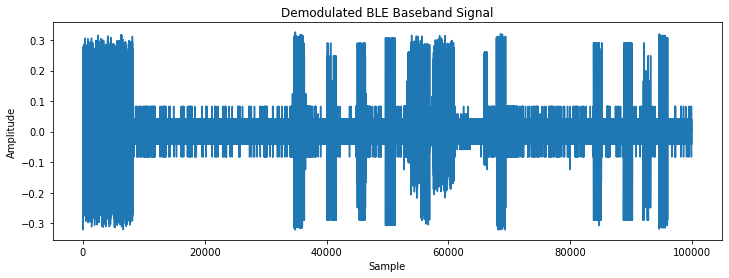

In [8]:
# 绘制解调信号
plt.figure(figsize=(12, 4))
plt.plot(baseband_signal[:100000])
plt.title('Demodulated BLE Baseband Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

## 解析BLE基带信号，提取MAC地址、UUID、数据包

In [9]:
# ✅ 加入进度条，生成比特流
print("\n[+] Generating bitstream...")
bit_stream = ''
for x in tqdm(baseband_signal, desc="Converting to Bitstream", unit="sample"):
    bit_stream += '1' if x > 0 else '0'


[+] Generating bitstream...


Converting to Bitstream:   1%|▌                                  | 17518447/1207700721 [00:30<34:13, 579472.44sample/s]


KeyboardInterrupt: 

In [10]:
# ✅ 解析 BLE 包
def parse_ble_packet(data):
    try:
        # 前导码
        preamble = data[:8]  # 8 bits
        if preamble not in ['10101010', '01010101']:
            print("[!] Invalid Preamble, skipping packet...")
            return None
        
        # 接入地址
        access_address = data[8:40]  # 32 bits
        print(f"[+] Access Address: {access_address}")
        
        # PDU 头部（16位）
        pdu_type = int(data[40:44], 2)
        length = int(data[44:52], 2)
        
        # MAC 地址（6字节 = 48位）
        mac_address = ':'.join(format(int(data[52 + i*8:52 + (i+1)*8], 2), '02X') for i in range(6))
        
        # 负载
        payload = data[100:100 + length * 8]
        
        print(f"[+] PDU Type: {pdu_type}")
        print(f"[+] Length: {length}")
        print(f"[+] MAC Address: {mac_address}")
        print(f"[+] Payload: {payload[:32]}...")

        return {
            "preamble": preamble,
            "access_address": access_address,
            "pdu_type": pdu_type,
            "length": length,
            "mac_address": mac_address,
            "payload": payload
        }
    except Exception as e:
        print(f"[!] Error parsing packet: {e}")
        return None

In [11]:
# ✅ 查找 BLE 数据包
print("\n[+] Searching for BLE packets...")
packet_len = 376  # BLE 每个完整包约 376 bits（8+32+16+48+最大255*8+24）
packets = []
for i in tqdm(range(0, len(bit_stream) - packet_len, packet_len), desc="Parsing Packets", unit="packet"):
    packet = bit_stream[i:i + packet_len]
    result = parse_ble_packet(packet)
    if result:
        packets.append(result)


[+] Searching for BLE packets...


Parsing Packets:   4%|██                                                   | 1858/46591 [00:00<00:02, 18493.60packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[+] Access Address: 01011000110101110100110001101010
[+] PDU Type: 5
[+] Length: 45
[+] MAC Address: 49:EC:65:75:AD:54
[+] Payload: 10100110111011001101010100101010...
[+] Access Address: 01011010110001110010100101101101
[+] PDU Type: 6
[+] Length: 166
[+] MAC Address: 71:6C:C9:A7:73:AA
[+] Payload: 11100100100110101000011011001010...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Inv

Parsing Packets:  12%|██████▎                                              | 5560/46591 [00:00<00:02, 18259.34packet/s]

[+] PDU Type: 5
[+] Length: 86
[+] MAC Address: 54:55:4D:4A:95:56
[+] Payload: 10101010101010101011010101010010...
[+] Access Address: 00101010101011010101010100101010
[+] PDU Type: 10
[+] Length: 149
[+] MAC Address: 52:AA:95:52:08:51
[+] Payload: 00001000010010000000000000000000...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamb

Parsing Packets:  20%|██████████▍                                          | 9208/46591 [00:00<00:02, 18165.41packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[+] Access Address: 00000000000000001000000000000010
[+] PDU Type: 5
[+] Length: 2
[+] MAC Address: 21:1F:FF:FF:FF:F1
[+] Payload: 0011100100111000...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skippin

Parsing Packets:  28%|██████████████▍                                     | 12962/46591 [00:00<00:01, 18457.35packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  36%|██████████████████▊                                 | 16891/46591 [00:00<00:01, 19072.05packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  41%|█████████████████████▏                              | 18989/46591 [00:01<00:01, 16837.78packet/s]

[+] MAC Address: 24:4C:25:25:04:95
[+] Payload: 00100101100010010010100100110100...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Pr

Parsing Packets:  49%|█████████████████████████▎                          | 22631/46591 [00:01<00:01, 17266.81packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  57%|█████████████████████████████▋                      | 26649/46591 [00:01<00:01, 18634.01packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  61%|███████████████████████████████▊                    | 28535/46591 [00:01<00:01, 17978.94packet/s]


[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Pre

Parsing Packets:  69%|████████████████████████████████████                | 32353/46591 [00:01<00:00, 18526.53packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  78%|████████████████████████████████████████▌           | 36331/46591 [00:01<00:00, 19185.03packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  86%|████████████████████████████████████████████▊       | 40170/46591 [00:02<00:00, 18474.90packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets:  95%|█████████████████████████████████████████████████▏  | 44115/46591 [00:02<00:00, 18519.98packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

Parsing Packets: 100%|████████████████████████████████████████████████████| 46591/46591 [00:02<00:00, 18238.54packet/s]

[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Preamble, skipping packet...
[!] Invalid Prea

In [12]:
print(f"\n[+] Found {len(packets)} valid BLE packets")


[+] Found 244 valid BLE packets


## 切分基带信号，按设备分离前导码并保存

In [13]:
output_file = 'D:\\RF-Fingerprint-Extraction-for-Bluetooth\\Extracted-Signals\\parsed_ble_packets.txt'
with open(output_file, 'w') as f:
    for pkt in packets:
        f.write(f"{pkt}\n")

In [14]:
print(f"[+] Saved parsed packets to {output_file}")

[+] Saved parsed packets to D:\RF-Fingerprint-Extraction-for-Bluetooth\Extracted-Signals\parsed_ble_packets.txt
